# Analyses de la résilience d'un essaim de nano-satellites

## Import packages

In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist

from swarm_sim import *



%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [14]:
PATH = 'Traces.csv'

df = pd.read_csv(PATH, sep=',', header=None)
satellites = {}

for i in range(0,100):
    sat = df.iloc[3*i : 3*i+3].copy()
    sat['coords'] = ['x','y','z']
    satellites[i] = sat.set_index('coords', drop=True)

satellites[0]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [15]:
RANGE = 60000

list_satellites = []

for i in range(len(satellites)):
    obj_sat = Node.__new__(Node)
    obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])
    list_satellites.append(obj_sat)

swarm = Swarm.__new__(Swarm)
swarm.__init__(RANGE, list_satellites)
graph = swarm.swarm_to_nxgraph()

/tmp/ipykernel_18212/204510953.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][0][0], satellites[i][0][1], satellites[i][0][2])


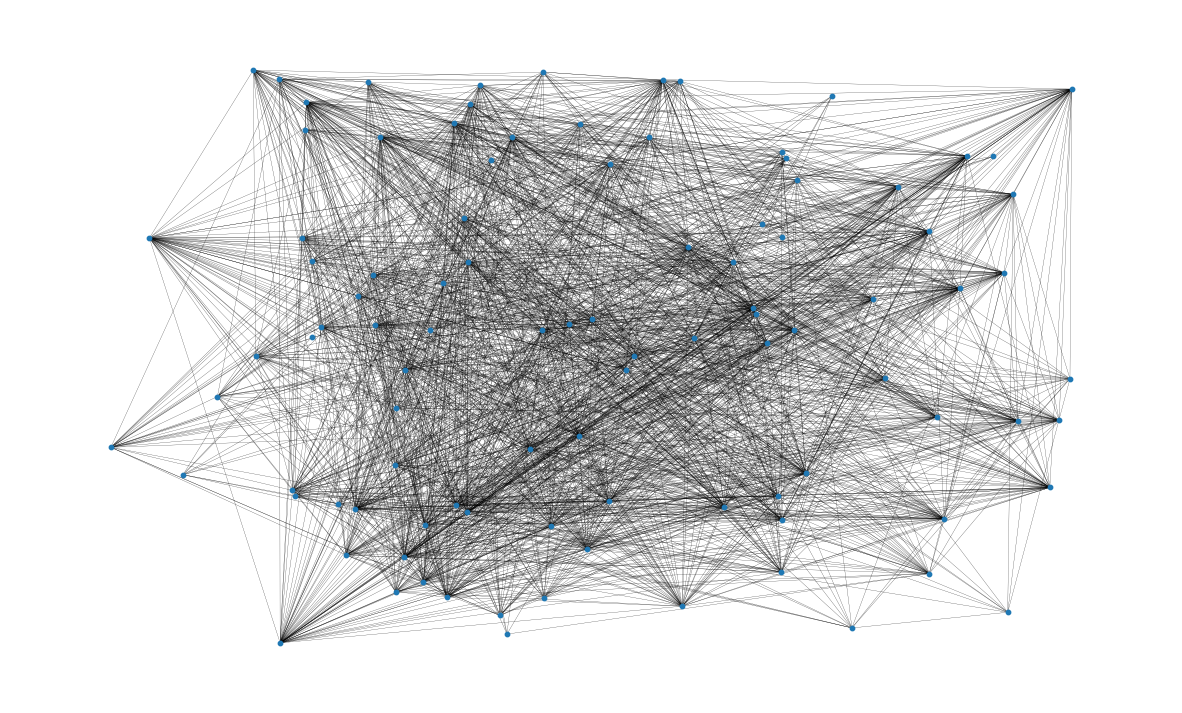

In [16]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(graph, pos=nx.random_layout(graph), ax=ax, **plot_options)

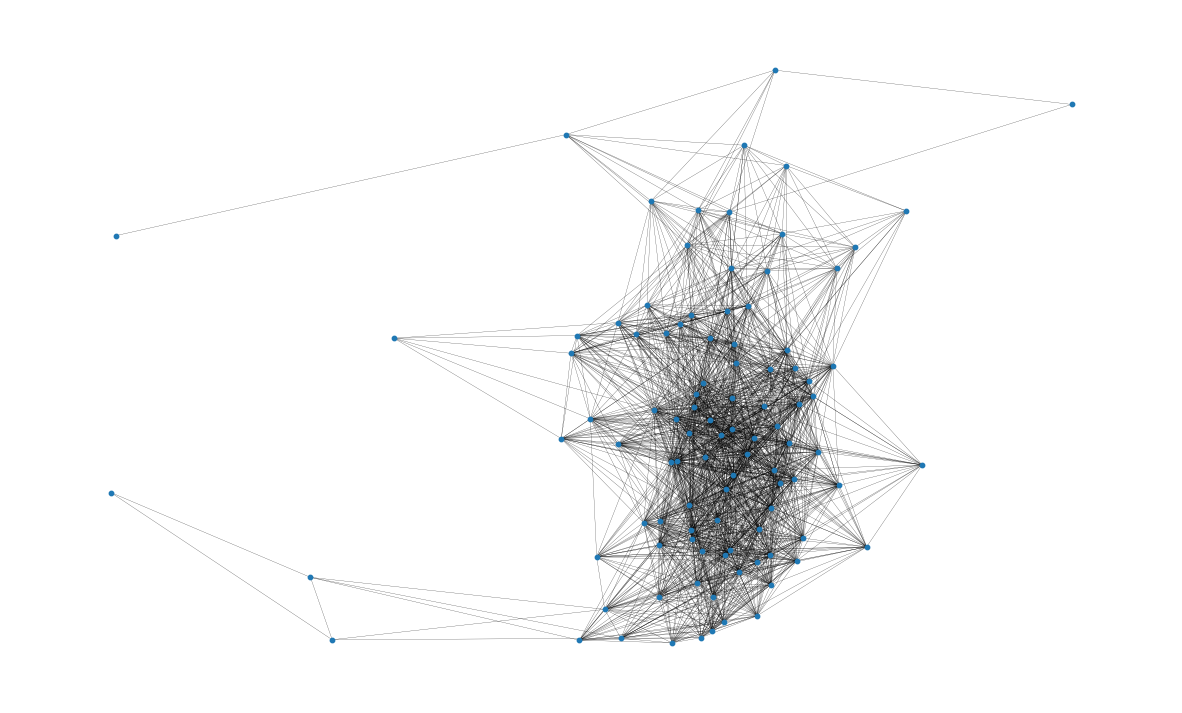

In [17]:
pos = nx.spring_layout(graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

## Robert Ludo

Voir si on supprime un nanosatellite qu'est ce que ça fait

In [18]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

def analyse_graphique_impact_df(PATH='Traces.csv', timestep=0, nb_to_remove=5, range_km=60.0, seed=None,
                                 NodeClass=None, SwarmClass=None, targeted=False, centrality=False, display=True):
    """
    Analyse graphique avec retour sous forme de DataFrame des métriques réseau avant/après suppression de satellites.

    Paramètres :
        - PATH : chemin vers le fichier CSV
        - timestep : temps à analyser (entre 0 et 9999)
        - nb_to_remove : nombre de satellites à supprimer
        - range_km : distance max pour la connexion (en km)
        - seed : graine pour reproductibilité
        - NodeClass : classe Node
        - SwarmClass : classe Swarm
        - targeted : True pour supprimer les plus connectés
        - centrality : True pour supprimer les plus centraux
        - display : affiche les graphes avant/après

    Retour :
        - DataFrame avec les métriques avant/après et la liste des satellites supprimés
    """
    random.seed(seed)
    RANGE = range_km * 1000  # conversion km -> m

    # Lecture du CSV
    df = pd.read_csv(PATH, sep=',', header=None)
    satellites = {}
    for i in range(100):
        sat = df.iloc[3*i:3*i+3].copy()
        sat['coords'] = ['x','y','z']
        satellites[i] = sat.set_index('coords', drop=True)

    list_satellites = []
    for i in range(len(satellites)):
        obj_sat = NodeClass.__new__(NodeClass)
        obj_sat.__init__(i, satellites[i][timestep][0], satellites[i][timestep][1], satellites[i][timestep][2])
        list_satellites.append(obj_sat)

    swarm = SwarmClass.__new__(SwarmClass)
    swarm.__init__(RANGE, list_satellites)
    graph_full = swarm.swarm_to_nxgraph()

    # Sélection des nœuds à supprimer
    if targeted:
        degrees = dict(graph_full.degree)
        to_remove = sorted(degrees, key=degrees.get, reverse=True)[:nb_to_remove]
    elif centrality:
        centrals = nx.betweenness_centrality(graph_full)
        to_remove = sorted(centrals, key=centrals.get, reverse=True)[:nb_to_remove]
    else:
        to_remove = random.sample(list(graph_full.nodes), nb_to_remove)

    graph_reduced = graph_full.copy()
    graph_reduced.remove_nodes_from(to_remove)

    # Fonction pour calculer les métriques
    def compute_metrics(G):
        return {
            "nb_nodes": G.number_of_nodes(),
            "nb_edges": G.number_of_edges(),
            "connectivity": nx.number_connected_components(G),
            "avg_degree": (sum(dict(G.degree).values()) / G.number_of_nodes()) if G.number_of_nodes() > 0 else 0,
            "avg_path_length": nx.average_shortest_path_length(G) if nx.is_connected(G) and G.number_of_nodes() > 1 else None
        }

    metrics_before = compute_metrics(graph_full)
    metrics_after = compute_metrics(graph_reduced)

    # Affichage des graphes
    if display:
        pos = nx.spring_layout(graph_full, iterations=15, seed=1721)
        fig, axs = plt.subplots(1, 2, figsize=(18, 9))
        for ax, G, title in zip(axs, [graph_full, graph_reduced], ["Avant panne", "Après panne"]):
            ax.axis("off")
            nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.15)
            ax.set_title(f"{title} — {range_km} km", fontsize=14)

    # Création DataFrame final
    df_result = pd.DataFrame([
        {"metric": k,
         "before": metrics_before[k],
         "after": metrics_after[k],
         "delta": (metrics_after[k] - metrics_before[k]) if metrics_after[k] is not None and metrics_before[k] is not None else None}
        for k in metrics_before
    ])
    df_result["removed_nodes"] = [to_remove] + [None] * (len(df_result) - 1)
    return df_result


/tmp/ipykernel_18212/3207768247.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_sat.__init__(i, satellites[i][timestep][0], satellites[i][timestep][1], satellites[i][timestep][2])


,metric,before,after,delta,removed_nodes
0,nb_nodes,100.00,80.000,-20.000,"[81, 14, 3, 94, 35, 31, 28, 17, 13, 86, 69, 11..."
1,nb_edges,174.00,107.000,-67.000,None
2,connectivity,26.00,23.000,-3.000,None
3,avg_degree,3.48,2.675,-0.805,None
4,avg_path_length,NaN,NaN,NaN,None


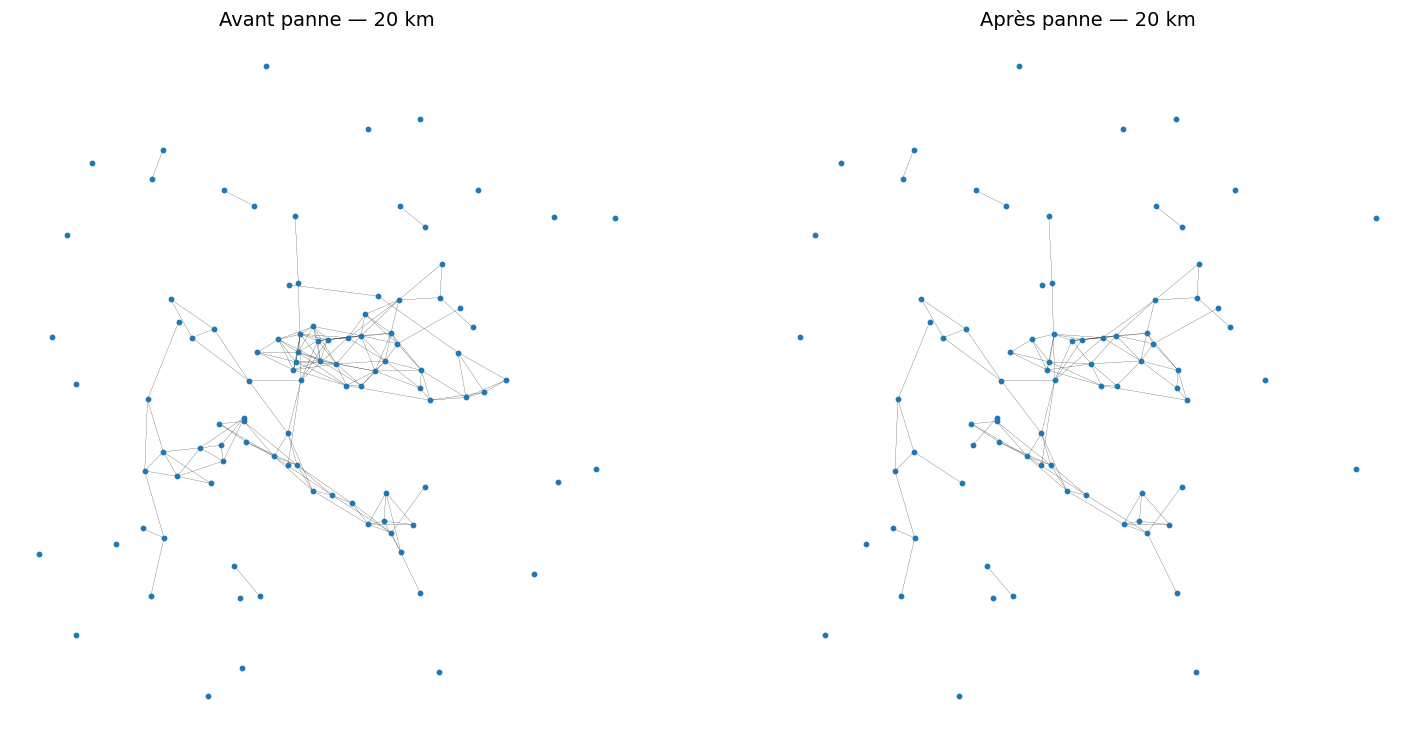

In [23]:
df_metrics = analyse_graphique_impact_df(
    PATH='Traces.csv',
    timestep=0,
    nb_to_remove=20,
    range_km=20,
    seed=42,
    NodeClass=Node,
    SwarmClass=Swarm,
    targeted=False,
    centrality=False,
    display=True
)

df_metrics


# Robert Emma

Actually, there are bridges in the network. Now the edges that are bridges will be saved in a list and the number of them is printed:

In [16]:
bridges = list(nx.bridges(G))
len(bridges)

0

The existence of so many bridges is due to the fact that this network only contains the spotlight nodes and the friends of them. As a result, some friends of spotlight nodes are only connected to a spotlight node, making that edge a bridge.

Also, the edges that are local bridges are saved in a list and their number is printed. In detaill, an edge joining two nodes $C$ and $D$ 
in a graph is a local bridge, if its endpoints $C$ and $D$ have no friends in common. Very importantly, an edge that is a bridge is also a local bridge. Thus, this list contains all the above bridges as well:

In [17]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

0

Showcasing the bridges and local bridges in the network now. The bridges can be seen with the red color and the local bridges with the green color. Black edges are neither local bridges nor bridges.

* It is clear that all the bridges concern nodes that are only connected to a spotlight node (have a degree of $1$)

(-0.9556550397616517,
 1.0633890724227726,
 -1.0306564545354944,
 1.096697926406452)

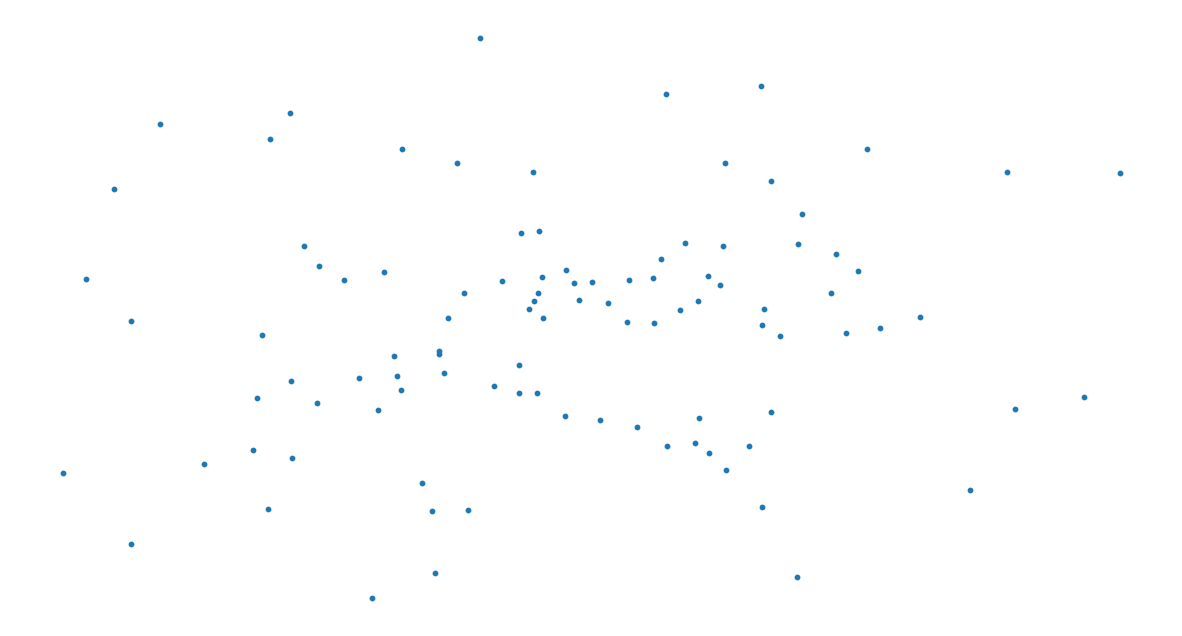

In [18]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")